In [1]:
import cv2
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from utils import *
import os

import pdb
from numpy.linalg import lstsq
from scipy.sparse.linalg import lsqr, spsolve
from scipy.sparse import csr_matrix, lil_matrix, linalg

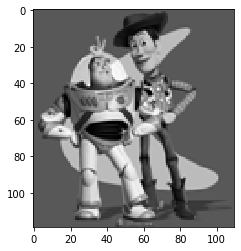

In [2]:
toy_img = cv2.cvtColor(cv2.imread('samples/toy_problem.png'), cv2.COLOR_BGR2RGB)
toy_img = cv2.cvtColor(toy_img, cv2.COLOR_BGR2GRAY).astype('double') / 255.0
plt.imshow(toy_img, cmap="gray")

## Part 1 Toy Problem (20 pts)

In [3]:
def toy_reconstruct(toy_img):
    """
    The implementation for gradient domain processing is not complicated, but it is easy to make a mistake, so let's start with a toy example. Reconstruct this image from its gradient values, plus one pixel intensity. Denote the intensity of the source image at (x, y) as s(x,y) and the value to solve for as v(x,y). For each pixel, then, we have two objectives:
    1. minimize (v(x+1,y)-v(x,y) - (s(x+1,y)-s(x,y)))^2
    2. minimize (v(x,y+1)-v(x,y) - (s(x,y+1)-s(x,y)))^2
    Note that these could be solved while adding any constant value to v, so we will add one more objective:
    3. minimize (v(1,1)-s(1,1))^2
    
    :param toy_img: numpy.ndarray
    """
    im = toy_img
    # Matrix "im2var" maps each pixel to a variable number
    im_h, im_w = im.shape[0], im.shape[1]
    im2var = np.arange(im_h*im_w).reshape(im_w, im_h).T
    
    # sparse matrixes for A and b to add constraints
    # y*(x-1) + (y-1)*x+1
    n_constraints = im_h*(im_w-1) + (im_h-1)*im_w+1 
    total_pixels = im_h*im_w
    # print("Constraints", n_constraints)
    # A = lil_matrix((n_constraints, total_pixels), dtype=np.float64)
    A = np.zeros((n_constraints, total_pixels), dtype=np.float64)
    b = np.zeros(n_constraints, dtype=np.float64)
    # print("Sparse Matrixes", A, b, A.shape, b.shape) #(25952, 13090) (25952,)

    # setup objective 3
    e = 0
    A[e][im2var[0][0]] = 1
    b[e] = im[0][0]    
    e = e + 1; # Equation counter
    
    # for each pixel, calculate gradient
    for y in range(im_h):
        for x in range(im_w):
            
            #Solve AX = B for every pixel under the mask.
            # objective 1
            if x != im2var.shape[1] - 1:
                A[e, im2var[y][x+1]] = 1
                A[e, im2var[y][x]] = -1
                b[e] = im[y][x+1] - im[y][x]
                e = e + 1
            
            # objective 2
            if y != im2var.shape[0] - 1:
                A[e, im2var[y+1][x]] = 1
                A[e, im2var[y][x]] = -1
                b[e] = im[y+1][x] - im[y][x]  
                e = e + 1
    
    # solve for v with least square. start with v = scipy.sparse.linalg.lsqr(A, b);
    v = lsqr(csr_matrix(A, dtype=np.float64), b)
    
    # img with 1 channel
    response = np.resize(v[0],(im_w, im_h)).T    
    return response

Error is:  0.00031701850079458095


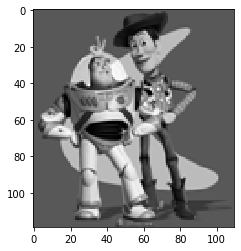

In [4]:
im_out = toy_reconstruct(toy_img)
if im_out.any():
    print("Error is: ", np.sqrt(((im_out - toy_img)**2).sum()))
plt.imshow(im_out, cmap='gray')

## Preparation

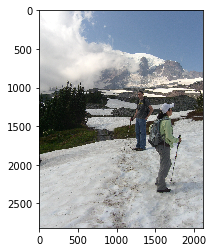

In [5]:
# Feel free to change image
background_img = cv2.cvtColor(cv2.imread('samples/im2.JPG'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
plt.figure()
plt.imshow(background_img)

If it doesn't get you to the drawing mode, then rerun this function again.


<IPython.core.display.Javascript object>


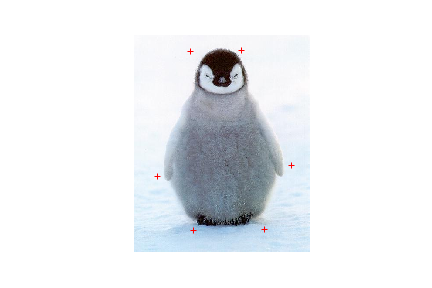

In [7]:
# Feel free to change image
object_img = cv2.cvtColor(cv2.imread('samples/penguin-chick.jpeg'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
import matplotlib.pyplot as plt
%matplotlib notebook
mask_coords = specify_mask(object_img)

<Figure size 432x288 with 0 Axes>

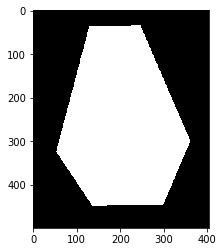

In [8]:
xs = mask_coords[0]
ys = mask_coords[1]
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure()
mask = get_mask(ys, xs, object_img)

If it doesn't get you to the drawing mode, then rerun this function again. Also, make sure the object fill fit into the background image. Otherwise it will crash


<IPython.core.display.Javascript object>


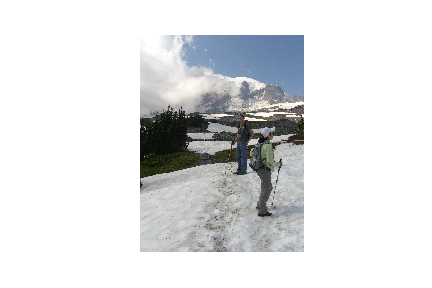

In [9]:
%matplotlib notebook
import matplotlib.pyplot as plt
bottom_center = specify_bottom_center(background_img)

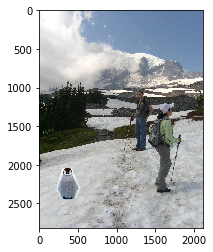

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
cropped_object, object_mask = align_source(object_img, mask, background_img, bottom_center)

## Part 2 Poisson Blending (50 pts)

In [11]:
def poisson_blend(cropped_object, object_mask, background_img):
    """
    :param cropped_object: numpy.ndarray One you get from align_source
    :param object_mask: numpy.ndarray One you get from align_source
    :param background_img: numpy.ndarray 
    """
    im = cropped_object;
    im_h, im_w = im.shape[0],im.shape[1]
    # print("Image Check", im_h, im_w)

    # Setup Results/Output Response
    output = np.zeros((im_h, im_w, 3), dtype=np.float64)
    
    # 3 Channels
    imageChannel = [
        cropped_object[:,:,0],
        cropped_object[:,:,1],
        cropped_object[:,:,2]
    ]
    
    channelNumber = 1
    channelIndex = 0
    
    for im in imageChannel:
        print("Starting Channel #" + str(channelNumber))
        # Setting up im2var = np.arange(im_h * im_w).reshape(im_h, im_w) with object mask
        im2var = []
        count = 0
        for row in range(im_h):
            tempColumn = []
            for column in range(im_w):
                if object_mask[row][column] == 1:
                    tempColumn.append(count)
                    count+=1
                else:
                    tempColumn.append(0)
            im2var.append(tempColumn)
        #print("im2var", im2var)
        #n_constraints = 2*im_h*(im_w-1) + 2*(im_h-1)*im_w + 1 
        n_constraints = 4*count + 1
        total_pixels = count
        #print("Constraints, Pixels", n_constraints, count)
        
        # sparse matrix for A and b
        A = lil_matrix((n_constraints,total_pixels),dtype=np.float64)
        #A = np.zeros((n_constraints,total_pixels),dtype=np.float64)
        b = np.zeros(n_constraints,dtype=np.float64)
        # print("Sparse Matrixes", A, b, A.shape, b.shape)
        e = 0
        
        #print("Calculating Gradient for Each Pixel")
        for y in range(im_h):
            for x in range(im_w):
                if object_mask[y][x]==1:
                    #1. x+1
                    if object_mask[y][x+1] == 1:
                        A[e, im2var[y][x]] = 1
                        A[e, im2var[y][x+1]] = -1
                        b[e] = im[y][x] - im[y][x+1]
                    else:
                        A[e, im2var[y][x]] = 1
                        b[e] = im[y][x] - im[y][x+1] + background_img[y][x+1][channelIndex]            
                    e = e + 1

                    #2. y+1
                    if object_mask[y+1][x] == 1:
                        A[e, im2var[y][x]] = 1
                        A[e, im2var[y+1][x]] = -1
                        b[e] =  im[y][x] - im[y+1][x]
                    else:
                        A[e, im2var[y][x]] = 1
                        b[e] = im[y][x] - im[y+1][x] + background_img[y+1][x][channelIndex]            
                    e = e + 1
                
                    #3. x-1
                    if object_mask[y][x-1] == 1:
                        A[e, im2var[y][x]] = 1
                        A[e, im2var[y][x-1]] = -1
                        b[e] =  im[y][x] - im[y][x-1]
                    else:
                        A[e, im2var[y][x]] = 1
                        b[e] = im[y][x] - im[y][x-1] + background_img[y][x-1][channelIndex]            
                    e = e + 1
                    
                    #4. y-1
                    if object_mask[y-1][x] == 1:
                        A[e, im2var[y][x]] = 1
                        A[e, im2var[y-1][x]] = -1
                        b[e] = im[y][x] - im[y-1][x]
                    else:
                        A[e, im2var[y][x]] = 1
                        b[e] = im[y][x] - im[y-1][x] + background_img[y-1][x][channelIndex]            
                    e = e + 1

        print("Constraint Solving V with Least Square.")
        v = lsqr(csr_matrix(A, dtype=np.float64), b)
       
        # Copy the solves values into target image.
        solveCount = 0
        for row in range(im_h):
            for column in range(im_w):
                if object_mask[row][column] == 1:
                    output[row][column][channelIndex] = v[0][solveCount]
                    solveCount += 1
                else:
                    output[row][column][channelIndex] = background_img[row][column][channelIndex]

        # Next Channel
        channelIndex += 1
        channelNumber += 1
        
    print("Blending Complete")
    return output

Starting Channel #1
Constraint Solving V with Least Square.
Starting Channel #2
Constraint Solving V with Least Square.
Starting Channel #3
Constraint Solving V with Least Square.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Blending Complete


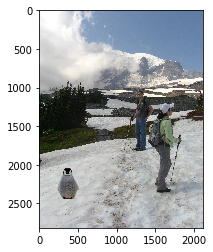

In [12]:
im_blend = poisson_blend(cropped_object, object_mask, background_img)
if im_blend.any():
    %matplotlib inline
    import matplotlib.pyplot as plt
    plt.imshow(im_blend)

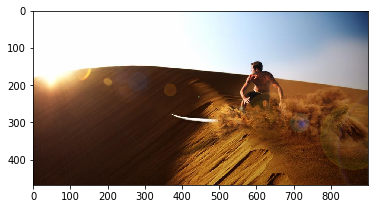

In [13]:
# Image 1
background_img2 = cv2.cvtColor(cv2.imread('samples/1-Target.JPG'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
plt.figure()
plt.imshow(background_img2)

If it doesn't get you to the drawing mode, then rerun this function again.


<IPython.core.display.Javascript object>


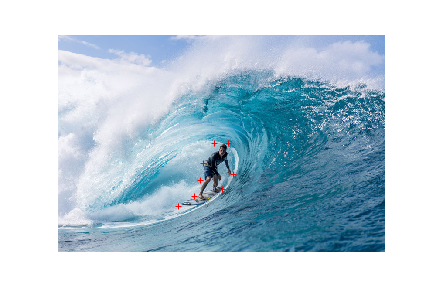

In [15]:
object_img2 = cv2.cvtColor(cv2.imread('samples/1-Source.JPG'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
import matplotlib.pyplot as plt
%matplotlib notebook
mask_coords2 = specify_mask(object_img2)

<Figure size 432x288 with 0 Axes>

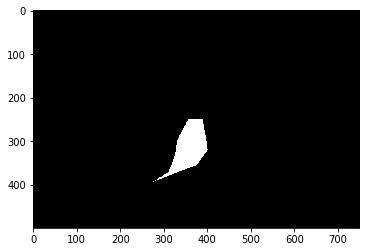

In [16]:
xs2 = mask_coords2[0]
ys2 = mask_coords2[1]
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure()
mask2 = get_mask(ys2, xs2, object_img2)

If it doesn't get you to the drawing mode, then rerun this function again. Also, make sure the object fill fit into the background image. Otherwise it will crash


<IPython.core.display.Javascript object>


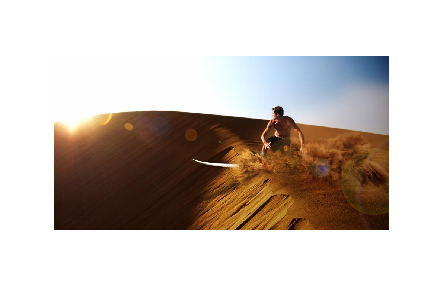

In [17]:
%matplotlib notebook
import matplotlib.pyplot as plt
bottom_center2 = specify_bottom_center(background_img2)

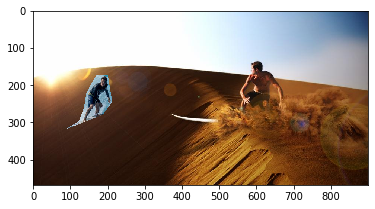

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
cropped_object2, object_mask2 = align_source(object_img2, mask2, background_img2, bottom_center2)

Starting Channel #1
Constraint Solving V with Least Square.
Starting Channel #2
Constraint Solving V with Least Square.
Starting Channel #3
Constraint Solving V with Least Square.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Blending Complete


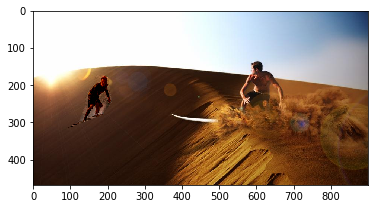

In [19]:
im_blend2 = poisson_blend(cropped_object2, object_mask2, background_img2)
if im_blend.any():
    %matplotlib inline
    import matplotlib.pyplot as plt
    plt.imshow(im_blend2)

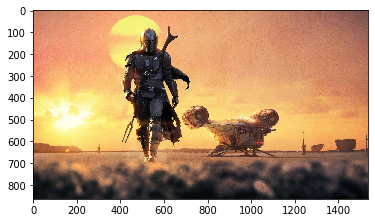

In [20]:
# Image 2
background_img3 = cv2.cvtColor(cv2.imread('samples/2-Target.JPG'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
plt.figure()
plt.imshow(background_img3)

If it doesn't get you to the drawing mode, then rerun this function again.


<IPython.core.display.Javascript object>


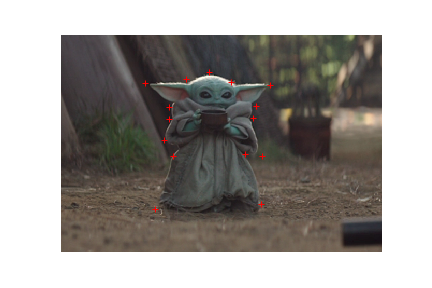

In [22]:
object_img3 = cv2.cvtColor(cv2.imread('samples/2-Source.PNG'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
import matplotlib.pyplot as plt
%matplotlib notebook
mask_coords3 = specify_mask(object_img3)

<Figure size 432x288 with 0 Axes>

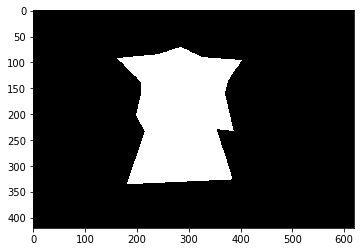

In [23]:
xs3 = mask_coords3[0]
ys3 = mask_coords3[1]
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure()
mask3 = get_mask(ys3, xs3, object_img3)

If it doesn't get you to the drawing mode, then rerun this function again. Also, make sure the object fill fit into the background image. Otherwise it will crash


<IPython.core.display.Javascript object>


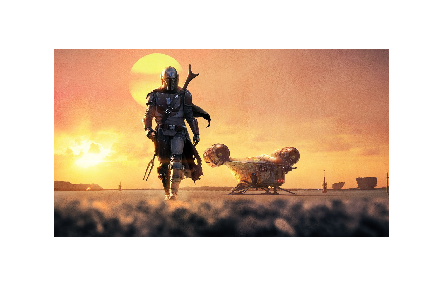

In [24]:
%matplotlib notebook
import matplotlib.pyplot as plt
bottom_center3 = specify_bottom_center(background_img3)

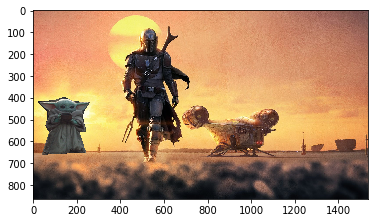

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt
cropped_object3, object_mask3 = align_source(object_img3, mask3, background_img3, bottom_center3)

Starting Channel #1
Constraint Solving V with Least Square.
Starting Channel #2
Constraint Solving V with Least Square.
Starting Channel #3
Constraint Solving V with Least Square.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Blending Complete


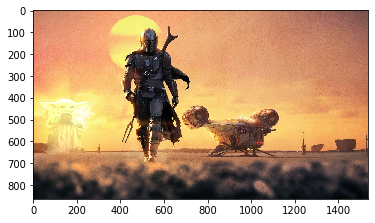

In [26]:
im_blend3 = poisson_blend(cropped_object3, object_mask3, background_img3)
if im_blend.any():
    %matplotlib inline
    import matplotlib.pyplot as plt
    plt.imshow(im_blend3)

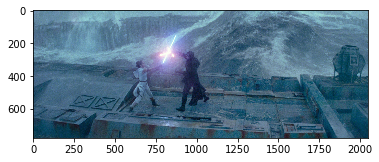

In [27]:
# Image 3
background_img4 = cv2.cvtColor(cv2.imread('samples/3-Target.JPG'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
plt.figure()
plt.imshow(background_img4)

In [ ]:
# object_img3 = cv2.cvtColor(cv2.imread('samples/2-Source.PNG'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
# import matplotlib.pyplot as plt
# %matplotlib notebook
# mask_coords3 = specify_mask(object_img3)

In [ ]:
# xs3 = mask_coords3[0]
# ys3 = mask_coords3[1]
# %matplotlib inline
# import matplotlib.pyplot as plt
# plt.figure()
# mask3 = get_mask(ys3, xs3, object_img3)

If it doesn't get you to the drawing mode, then rerun this function again. Also, make sure the object fill fit into the background image. Otherwise it will crash


<IPython.core.display.Javascript object>


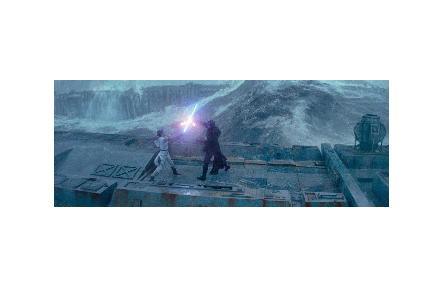

In [29]:
%matplotlib notebook
import matplotlib.pyplot as plt
bottom_center4 = specify_bottom_center(background_img4)

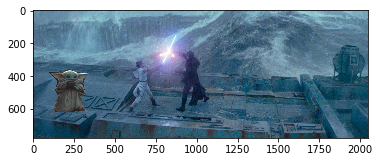

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt
cropped_object4, object_mask4 = align_source(object_img3, mask3, background_img4, bottom_center4)

Starting Channel #1
Constraint Solving V with Least Square.
Starting Channel #2
Constraint Solving V with Least Square.
Starting Channel #3
Constraint Solving V with Least Square.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Blending Complete


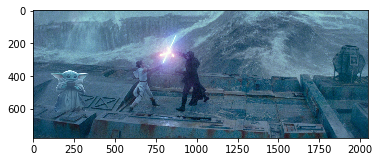

In [31]:
im_blend4 = poisson_blend(cropped_object4, object_mask4, background_img4)
if im_blend.any():
    %matplotlib inline
    import matplotlib.pyplot as plt
    plt.imshow(im_blend4)

## Part 3 Mixed Gradients (20 pts)

In [32]:
#"d_ij" is the value of the gradient from the source or the target image with larger magnitude.
#Note that larger magnitude is not the same as greater value. -> use abs()
def d_ij(source_x, source_y, target_x, target_y):
    sourceValue = source_x - source_y
    targetValue = target_x - target_y
    sourceMagnitude = abs(sourceValue)
    targetMagnitude = abs(targetValue)
    if (sourceMagnitude > targetMagnitude):
        return sourceValue
    else:
        return targetValue

def mix_blend(cropped_object, object_mask, background_img):
    """
    :param cropped_object: numpy.ndarray One you get from align_source
    :param object_mask: numpy.ndarray One you get from align_source
    :param background_img: numpy.ndarray 
    """
    im = cropped_object/255;
    im_h, im_w = im.shape[0],im.shape[1]
    # print("Image Check", im_h, im_w)

    # Setup Results/Output Response
    output = np.zeros((im_h, im_w, 3), dtype=np.float64)
    
    # 3 Channels
    imageChannel = [
        cropped_object[:,:,0],
        cropped_object[:,:,1],
        cropped_object[:,:,2]
    ]
    
    channelNumber = 1
    channelIndex = 0
    
    for im in imageChannel:
        print("Starting Channel #" + str(channelNumber))

        # Setting up im2var = np.arange(im_h * im_w).reshape(im_h, im_w) with object mask
        im2var = []
        count = 0
        for row in range(im_h):
            tempColumn = []
            for column in range(im_w):
                if object_mask[row][column] == 1:
                    tempColumn.append(count)
                    count+=1
                else:
                    tempColumn.append(0)
            im2var.append(tempColumn)
        
        #print("im2var", im2var)
        #n_constraints = 2*im_h*(im_w-1) + 2*(im_h-1)*im_w + 1 
        n_constraints = 4*count + 1
        total_pixels = count
        #print("Constraints, Pixels", n_constraints, count)
        
        # sparse matrix for A and b
        A = lil_matrix((n_constraints,total_pixels),dtype=np.float64)
        #A = np.zeros((n_constraints,total_pixels),dtype=np.float64)
        b = np.zeros(n_constraints,dtype=np.float64)
        # print("Sparse Matrixes", A, b, A.shape, b.shape)
        e = 0
        
        #print("Calculating Gradient for Each Pixel")
        for y in range(im_h):
            for x in range(im_w):
                if object_mask[y][x]==1:
                    #1. x+1
                    if object_mask[y][x+1] == 1:
                        A[e, im2var[y][x]] = 1
                        A[e, im2var[y][x+1]] = -1
                        b[e] = d_ij(im[y][x], im[y][x+1], background_img[y][x][channelIndex], background_img[y][x+1][channelIndex])
                    else:
                        A[e, im2var[y][x]] = 1
                        b[e] = d_ij(im[y][x], im[y][x+1], background_img[y][x][channelIndex], background_img[y][x+1][channelIndex]) + background_img[y][x+1][channelIndex]
                    e = e + 1
                    
                    #2. y+1
                    if object_mask[y+1][x] == 1:
                        A[e, im2var[y][x]] = 1
                        A[e, im2var[y+1][x]] = -1
                        b[e] = d_ij(im[y][x], im[y+1][x], background_img[y][x][channelIndex], background_img[y+1][x][channelIndex])
                    else:
                        A[e, im2var[y][x]] = 1
                        b[e] = d_ij(im[y][x], im[y+1][x], background_img[y][x][channelIndex], background_img[y+1][x][channelIndex]) + background_img[y+1][x][channelIndex]
                    e = e + 1
                
                    #3. x-1
                    if object_mask[y][x-1] == 1:
                        A[e, im2var[y][x]] = 1
                        A[e, im2var[y][x-1]] = -1
                        b[e] = d_ij(im[y][x], im[y][x-1], background_img[y][x][channelIndex], background_img[y][x-1][channelIndex])
                    else:
                        A[e, im2var[y][x]] = 1
                        b[e] = d_ij(im[y][x], im[y][x-1], background_img[y][x][channelIndex], background_img[y][x-1][channelIndex]) + background_img[y][x-1][channelIndex]      
                    e = e + 1
                    
                    #4. y-1
                    if object_mask[y-1][x] == 1:
                        A[e, im2var[y][x]] = 1
                        A[e, im2var[y-1][x]] = -1
                        b[e] = d_ij(im[y][x], im[y-1][x], background_img[y][x][channelIndex], background_img[y-1][x][channelIndex])
                    else:
                        A[e, im2var[y][x]] = 1
                        b[e] = d_ij(im[y][x], im[y-1][x], background_img[y][x][channelIndex], background_img[y-1][x][channelIndex]) + background_img[y-1][x][channelIndex]
                    e = e + 1

        print("Constraint Solving V with Least Square.")
        v = lsqr(csr_matrix(A, dtype=np.float64), b)
       
        # Copy the solves values into target image.
        solveCount = 0
        for row in range(im_h):
            for column in range(im_w):
                if object_mask[row][column] == 1:
                    output[row][column][channelIndex] = v[0][solveCount]
                    solveCount += 1
                else:
                    output[row][column][channelIndex] = background_img[row][column][channelIndex]

        # Next Channel
        channelIndex += 1
        channelNumber += 1
        
    print("Blending Complete")
    return output

Starting Channel #1
Constraint Solving V with Least Square.
Starting Channel #2
Constraint Solving V with Least Square.
Starting Channel #3
Constraint Solving V with Least Square.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Blending Complete


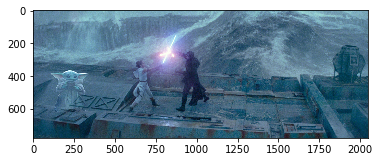

In [33]:
# Image Set 1
im_mix = mix_blend(cropped_object4, object_mask4, background_img4)
if im_mix.any():
    %matplotlib inline
    import matplotlib.pyplot as plt
    plt.imshow(im_mix)

Starting Channel #1
Constraint Solving V with Least Square.
Starting Channel #2
Constraint Solving V with Least Square.
Starting Channel #3
Constraint Solving V with Least Square.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Blending Complete


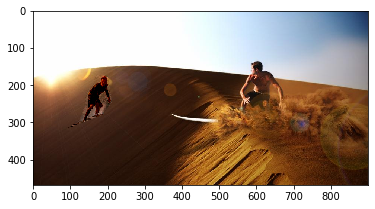

In [34]:
# Image Set 2
im_mix1 = mix_blend(cropped_object2, object_mask2, background_img2)
if im_mix.any():
    %matplotlib inline
    import matplotlib.pyplot as plt
    plt.imshow(im_mix1)

# Bells & Whistles (Extra Points)

## Color2Gray (20 pts)

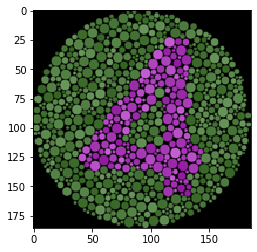

In [36]:
colorBlind4 = cv2.imread('samples/colorBlind4.png')
plt.imshow(colorBlind4)

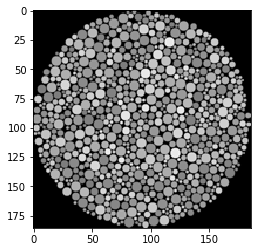

In [37]:
grey4 = cv2.cvtColor(colorBlind4, cv2.COLOR_BGR2GRAY)
plt.imshow(grey4, cmap="gray")

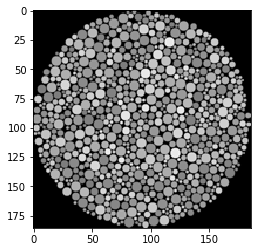

In [38]:
colorBlind8 = cv2.imread('samples/colorBlind8.png')
grey8 = cv2.cvtColor(cv2.imread('samples/colorBlind4.png'), cv2.COLOR_BGR2GRAY).astype('double') / 255.0
plt.imshow(grey8, cmap="gray")

In [46]:
# Copied over toy problem + mixed gradient functions & update gradient calculation.
def grayGradient(source_i, source_j):
    maximum = 0
    channel = 0
    while channel < 3:
        diff = source_i[channel] - source_j[channel]
        if abs(diff) > abs(maximum):
            maximum = diff
        channel+=1
    return maximum
# minimum setup
#     minimum = 1000
#     channel = 0
#     while channel < 3:
#         diff = source_i[channel] - source_j[channel]
#         if abs(diff) < abs(minimum):
#             minimum = diff
#         channel+=1
#     return min
# average setup
#     total = 0
#     channel = 0
#     while channel < 3:
#         diff = source_i[channel] - source_j[channel]
#         total += diff
#         channel+=1
#     return total/3

def color2gray(img):
    im = img
    im_h, im_w = im.shape[0], im.shape[1]
    im2var = np.arange(im_h*im_w).reshape(im_w, im_h).T
    
    n_constraints = im_h*(im_w-1) + (im_h-1)*im_w+1 
    total_pixels = im_h*im_w
    A = np.zeros((n_constraints, total_pixels), dtype=np.float64)
    b = np.zeros(n_constraints, dtype=np.float64)

    e = 0
    A[e][im2var[0][0]] = 1
    #b[e] = grey4[0][0]
    b[e] = 0
    e = e + 1;

    for y in range(im_h):
        for x in range(im_w):
            if x != im2var.shape[1] - 1:
                A[e, im2var[y][x]] = 1
                A[e, im2var[y][x+1]] = -1
                #A[e, im2var[y][x]] = -1
                #A[e, im2var[y][x+1]] = 1
                b[e] = grayGradient(im[y][x], im[y][x+1])
                e = e + 1
                
            if y != im2var.shape[0] - 1:
                A[e, im2var[y][x]] = 1
                A[e, im2var[y+1][x]] = -1
                #A[e, im2var[y][x]] = -1
                #A[e, im2var[y+1][x]] = 1
                b[e] = grayGradient(im[y][x], im[y+1][x])
                e = e + 1

    print("Ready")
    v = lsqr(csr_matrix(A, dtype=np.float64), b)
    print("Done")
    response = np.resize(v[0],(im_w, im_h)).T    
    return response

In [47]:
userGrey4 = color2gray(colorBlind4.astype("float64"))
userGrey8 = color2gray(colorBlind8.astype("float64"))

Ready
Done
Ready
Done


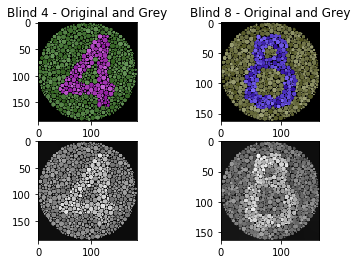

In [48]:
fig, axes = plt.subplots(2, 2)
axes[0, 0].imshow(colorBlind4)
axes[0, 0].set_title('Blind 4 - Original and Grey')
axes[0, 1].imshow(colorBlind8)
axes[0, 1].set_title('Blind 8 - Original and Grey')
axes[1, 0].imshow(userGrey4, cmap='gray')
axes[1, 1].imshow(userGrey8, cmap='gray')

## Laplacian pyramid blending (20 pts)

In [49]:
# def laplacian_blend(img1, img2):
#     pass

def gaussianPyramid(image, levels):
    down = image.copy()
    gaussianPyr = [down]
    for i in range(levels):
        down = cv2.pyrDown(down)
        gaussianPyr.append(np.float64(down))
    return gaussianPyr

def laplacianPyramid(gaussianPyr):
    levels = len(gaussianPyr) - 1
    laplacianPyramidOutput = [gaussianPyr[levels-1]]
    for i in range(levels - 1 , 0, -1):
        gaussianUp = cv2.pyrUp(gaussianPyr[i])[:gaussianPyr[i-1].shape[0], :gaussianPyr[i-1].shape[1],:]
        laplacianUp = np.subtract(gaussianPyr[i-1], gaussianUp)
        laplacianPyramidOutput.append(np.float64(laplacianUp))
    return laplacianPyramidOutput

def laplacian_blend(img1, img2, objMask):
    # Mask setup, img1 is cropped_object
    mask = np.zeros((img1.shape[0], img2.shape[1], 3), dtype=np.float64)
    for i in range(3):
        mask[:,:,i] = objMask
        
#     mask = [
#         objMask[:,:,0],
#         objMask[:,:,1],
#         objMask[:,:,2]
#     ]
    levels = 100
    
    # gaussian pyramids for both images and mask
    gaussianPyramidImage1 = gaussianPyramid(img1, levels)    
    gaussianPyramidImage2 = gaussianPyramid(img2, levels)
    gaussianPyramindMask = gaussianPyramid(mask, levels)
    gaussianPyramindMask.reverse()
    
    # laplacian pyramids for both images
    laplacianPyramidImage1 = laplacianPyramid(gaussianPyramidImage1)
    laplacianPyramidImage2 = laplacianPyramid(gaussianPyramidImage2)
        
    # Blend each level according to mask
    LS = []
    for la, lb, mask in zip(laplacianPyramidImage1, laplacianPyramidImage2, gaussianPyramindMask[1:]):
        ls = la * mask + lb * (1.0 - mask)    
        LS.append(ls)

    # Reconstruct
    laplacianResult = LS[0]
    for i in range(1, levels):
        laplacianUp = cv2.pyrUp(laplacianResult)
        laplacianResult = cv2.add(laplacianUp[:LS[i].shape[0],:LS[i].shape[1]], np.float64(LS[i]))
        
    return laplacianResult

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


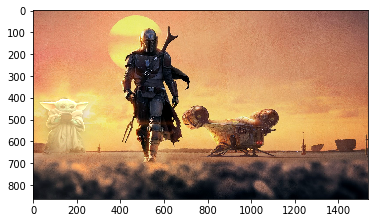

In [50]:
laplacianResult = laplacian_blend(cropped_object3, background_img3, object_mask3)
plt.imshow(laplacianResult)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


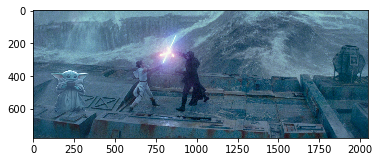

In [51]:
laplacianResult = laplacian_blend(cropped_object4, background_img4, object_mask4)
plt.imshow(laplacianResult)

## More gradient domain processing (up to 20 pts)

In [52]:
# Consider texture transfer

# Update helper functions
# The main difference between this function and quilt_cut is that there is an additional cost term 
# based on the difference between the sampled source patch and the target patch at the location to be filled.
def allPatches(sample, patch_size):
    allPatchesDict = {}
    countIndex = 0
    #print("Sample", sample.shape)
    for x in range(sample.shape[0]):
        if sample.shape[0] - x < patch_size:
            break
        for y in range(sample.shape[1]):
            #print("Sample[0, 1]", sample.shape[0], sample.shape[1])
            if sample.shape[1] - y < patch_size:
                continue
            allPatchesDict[countIndex] = sample[x : x + patch_size, y : y + patch_size, :]
            countIndex += 1       
    #print("All Patches", allPatchesDict)
    return allPatchesDict

def ssd_patch2(M, T, I):
    template = np.zeros(I.shape)
    template[:,:,0], template[:,:,1], template[:,:,2] = M * I[:,:,0], M * I[:,:,1], M * I[:,:,2]
    return np.sum((T - template) ** 2, -1)

def addSampleToResultImage(x, y, overlap, patch_size, updatedSample, output):
    overlapPixels = overlap // 2
    endX = x + patch_size
    endY = y + patch_size
    
    if x == 0 and y == 0:
        output[x : endX, y : endY] = updatedSample
    elif x == 0 and y != 0:
        output[x: endX, y + overlapPixels : endY] = updatedSample[:, overlapPixels:, :]
    elif x != 0 and y == 0:
        output[x + overlapPixels : endX, y : endY] = updatedSample[overlapPixels:, :, :]
    else:
        output[x + overlapPixels : endX, y + overlapPixels : endY] = updatedSample[overlapPixels:, overlapPixels:, :]

def choose_sample_with_extra_cost(targetImage, patch_size, M, T, tol, allPatchesDict):
    tolerance = tol
    imageCosts = {}
    imageCostSSD = {}
    candidates = []
    imageCostsArray = []
    randomIndex = (np.random.choice(len(allPatchesDict), int(0.01 * len(allPatchesDict))))

    for i in randomIndex:
        # calculating the additional cost. as noted from the paper
        alpha = np.sum(M) / (M.shape[0] * M.shape[1])  
        cost = ssd_patch2(M, T, allPatchesDict[i])
        cost2 = ssd_patch2(np.ones([patch_size, patch_size]), targetImage, allPatchesDict[i])
        imageCosts[i] = alpha * np.sum(cost) + (1 - alpha) * np.sum(cost2)
        imageCostSSD[i] = cost

    minc = min(imageCosts.values()) 
    for key in imageCosts.keys():
        if imageCosts[key] <= minc * (1 + tolerance):
            candidates.append(allPatchesDict[key])
            imageCostsArray.append(imageCostSSD[key])

    randomIndexSelection = np.random.choice(len(candidates))
    return candidates[randomIndexSelection], imageCostsArray[randomIndexSelection]

def cut(err_patch):
    """
    Compute the minimum path frm the left to right side of the patch
    
    :param err_patch: numpy.ndarray    cost of cutting through each pixel
    :return: numpy.ndarray             a 0-1 mask that indicates which pixels should be on either side of the cut
    """
    
    # create padding on top and bottom with very large cost
    padding = np.expand_dims(np.ones(err_patch.shape[1]).T*1e10,0)
    err_patch = np.concatenate((padding, err_patch, padding), axis=0)
    h, w = err_patch.shape
    path = np.zeros([h,w], dtype="int")
    cost = np.zeros([h,w])
    cost[:,0] = err_patch[:, 0]
    cost[0,:] = err_patch[0, :]
    cost[cost.shape[0]-1,:] = err_patch[err_patch.shape[0]-1, :]
    
    # for each column, compute the cheapest connected path to the left
    # cost of path for each row from left upper/same/lower pixel
    for x in range(1,w):
        # cost of path for each row from left upper/same/lower pixel
        tmp = np.vstack((cost[0:h-2,x-1], cost[1:h-1, x-1], cost[2:h, x-1]))
        mi = tmp.argmin(axis=0)
        path[1:h-1, x] = np.arange(1, h-1, 1).T + mi # save the next step of the path
        cost[1:h-1, x] = cost[path[1:h-1, x] - 1, x-1] + err_patch[1:h-1, x]

    path = path[1:path.shape[0]-1, :] - 1
    cost = cost[1:cost.shape[0]-1, :]

    # create the mask based on the best path
    mask = np.zeros(path.shape, dtype="int")
    best_path = np.zeros(path.shape[1], dtype="int")
    best_path[len(best_path)-1] = np.argmin(cost[:, cost.shape[1]-1]) + 1
    mask[0:best_path[best_path.shape[0]-1], mask.shape[1]-1] = 1
    for x in range(best_path.size-1, 0, -1):
        best_path[x-1] = path[best_path[x]-1, x]
        mask[:best_path[x-1], x-1] = 1
    mask ^= 1
    return mask

def texture_transfer(texture, target, patch_size, overlap, tol):
    texture = texture.copy() / 255.0
    output = target.copy() / 255.0
    patches = allPatches(texture, patch_size)
    
    for x in range(0, target.shape[0], patch_size - overlap):
        overlapX = x + overlap
        endX = x + patch_size
        if target.shape[0] - x < patch_size:
            break
        for y in range(0, target.shape[1], patch_size - overlap):
            overlapY = y + overlap
            endY = y + patch_size
            if target.shape[1] - y < patch_size:
                continue
            M = (output[x : endX, y : endY, 0] != 0).astype(int)
            T = (output[x : endX, y : endY, :])
            newTexturedImage, cost = choose_sample_with_extra_cost(output[x:endX, y:endY], patch_size, M, T, tol, patches)
            
            if x == 0 and y == 0:
                addSampleToResultImage(x, y, overlap, patch_size, newTexturedImage, output)
            elif x == 0 and y != 0:
                template = cost[:, 0 : overlap]
                mask1 = cut(template.T).T
                overlappedRegion = output[x : endX, y: overlapY, :]
                for z in range(3):
                    overlappedRegion[:,:,z] = newTexturedImage[:,:overlap,z] * mask1  + (1 - mask1) * overlappedRegion[:,:,z]
                output[x:endX, overlapY:endY,:] = newTexturedImage[:, overlap:,:]
            elif x != 0 and y == 0:
                mask2 = cut(cost[0 : overlap, :]) 
                overlappedRegion = output[x : overlapX, y: endY, :]
                for z in range(3):
                    overlappedRegion[:,:,z] =  newTexturedImage[:overlap,:,z] * mask2  + (1 - mask2) * overlappedRegion[:,:,z]
                output[overlapX:endX, y:endY,:] = newTexturedImage[overlap:,:,:]
            else:
                template = cost[:, 0 : overlap]
                mask3 = cut(template.T).T
                overlappedRegion = output[x : endX, y: overlapY, :]
                for z in range(3):
                    overlappedRegion[:,:,z] = newTexturedImage[:,:overlap,z] * mask3  + (1 - mask3) * overlappedRegion[:,:,z]
                mask4 = cut(cost[0 : overlap, :])
                overlappedRegion = output[x : overlapX, y: endY, :]
                for z in range(3):
                    overlappedRegion[:,:,z] =  newTexturedImage[:overlap,:,z] * mask4  + (1 - mask4) * overlappedRegion[:,:,z]
                output[overlapX:endX, overlapY:endY,:] = newTexturedImage[overlap:,overlap:,:]
    return output

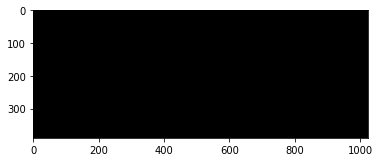

In [54]:
# Image Result #1.
# background_img4 = cv2.cvtColor(cv2.imread('samples/3-Target.JPG'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
backTT = cv2.pyrDown(background_img4)
objTT = cv2.pyrDown(cropped_object4)
ttResult = texture_transfer(objTT, backTT, 150, 50, 0.5)
plt.imshow(ttResult)